### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 4


### Дисциплина: Методы машинного обучения

##### Студент:  Абдуллина Ляйсан Раисовна
##### Группа:   НПИбд-01-21

## Москва 2024
***

### Вариант № 16

1. Набор данных: titanic

2. Независимые признаки: age, fare

3. Метка класса: pclass

4. Показатель бинарной классификации:

𝐹𝑃 (False Positives) – число точек в отрицательном классе, ошибочно спрогнозированных в положительный класс

5. Параметры нейронных сетей:

Кол-во скрытых слоев: 2, 3, 4

Кол-во нейронов в слоях задать так, чтобы общее количество параметров в разных сетях было примерно одинаковым.

Оптимизатор: Adam

Функция активации в скрытых слоях: selu

***

Загрузим все необходимые библиотеки

In [365]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import rcParams

1. Загрузите заданный в индивидуальном задании набор данных из Tensorflow Datasets, включая указанные в задании независимые признаки и метку класса. Оставьте в наборе признаки, принимающие числовые значения.

In [366]:
ds = tfds.load("titanic", split="train")
df = tfds.as_dataframe(ds)
df.head()

,age,boat,body,cabin,embarked,fare,home.dest,name,parch,pclass,sex,sibsp,survived,ticket
0,30.0,b'Unknown',-1,b'Unknown',2,13.0000,"b'Sarnia, ON'","b'McCrie, Mr. James Matthew'",0,1,0,0,0,b'233478'
1,37.0,b'Unknown',98,b'Unknown',2,7.9250,"b'Ruotsinphytaa, Finland New York, NY'","b'Gustafsson, Mr. Anders Vilhelm'",0,2,0,2,0,b'3101276'
2,28.0,b'9',-1,b'Unknown',2,13.0000,b'Spain',"b'Reynaldo, Ms. Encarnacion'",0,1,1,0,1,b'230434'
3,18.0,b'Unknown',-1,b'Unknown',2,73.5000,"b'Lyndhurst, England'","b'Davies, Mr. Charles Henry'",0,1,0,0,0,b'S.O.C. 14879'
4,-1.0,b'Unknown',-1,b'Unknown',0,7.8958,b'Unknown',"b'Gheorgheff, Mr. Stanio'",0,2,0,0,0,b'349254'


Оставим в наборе данных признаки, принимающие непрерывные числовые значения, включая независимые переменные (age, fare) и метку класса (pclass) .

In [367]:
df.drop(columns = ['boat', 'cabin', 'home.dest', 'name', 'ticket'], inplace = True)
df.head()
# df

,age,body,embarked,fare,parch,pclass,sex,sibsp,survived
0,30.0,-1,2,13.0000,0,1,0,0,0
1,37.0,98,2,7.9250,0,2,0,2,0
2,28.0,-1,2,13.0000,0,1,1,0,1
3,18.0,-1,2,73.5000,0,1,0,0,0
4,-1.0,-1,0,7.8958,0,2,0,0,0


2. Визуализируйте точки набора данных на плоскости с координатами, соответствующими двум независимым признакам (age, fare), отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду для классов набора данных.

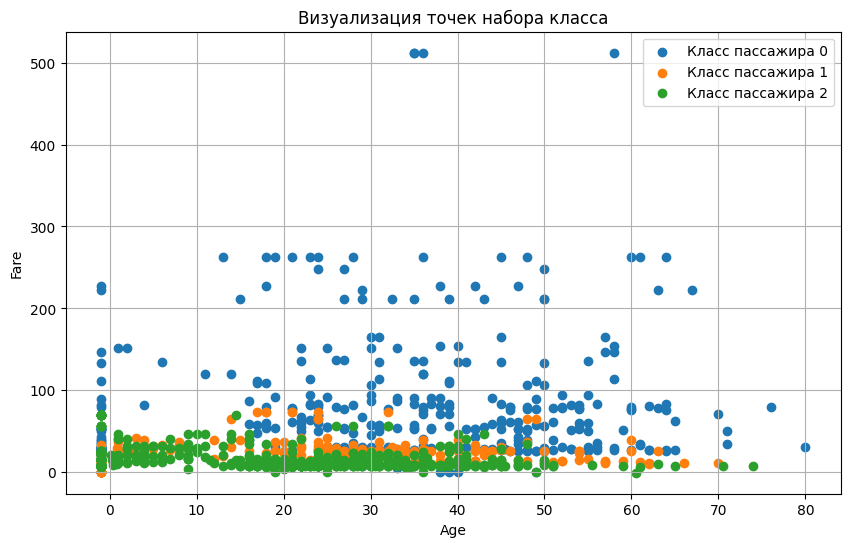

In [368]:
plt.figure(figsize=(10, 6))

for class_label, class_df in df.groupby('pclass'):
    plt.scatter(class_df['age'], class_df['fare'], label=f'Класс пассажира {class_label}')

plt.title('Визуализация точек набора класса')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.legend()
plt.grid(True)
plt.show()

Я решила убрать верхние выбросы, чтобы они не оказывали сильного воздействия

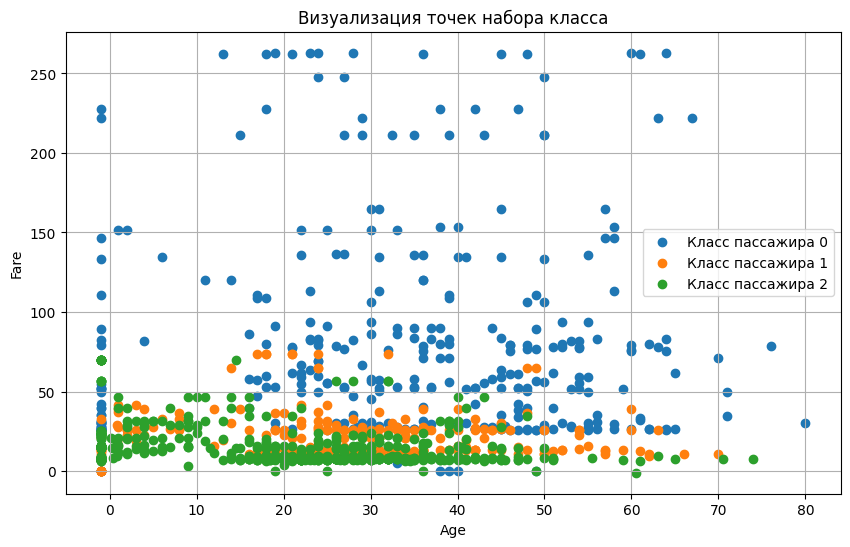

In [369]:
df = df[df['fare'] <= 300]

plt.figure(figsize=(10, 6))

for class_label, class_df in df.groupby('pclass'):
    plt.scatter(class_df['age'], class_df['fare'], label=f'Класс пассажира {class_label}')

plt.title('Визуализация точек набора класса')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.legend()
plt.grid(True)
plt.show()

3. Если признак с метками классов содержит более двух классов, то объедините некоторые классы, чтобы получить набор для бинарной классификации. Объединяйте классы таким образом, чтобы положительный и отрицательный классы были сопоставимы по количеству точек.  

In [370]:
df['pclass'].value_counts()

pclass
2    709
0    319
1    277
Name: count, dtype: int64

In [371]:
class_counts = df['pclass'].value_counts()

min_class = class_counts.idxmin()
max_class = class_counts.idxmax()

df['pclass'] = df['pclass'].replace({min_class: 0, max_class: 1})
df['pclass'].value_counts()

<ipython-input-371-a0eb62fba9d7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pclass'] = df['pclass'].replace({min_class: 0, max_class: 1})


pclass
1    709
0    596
Name: count, dtype: int64

4. Разбейте набор данных из двух признаков и бинарных меток класса на обучающую и тестовую выборки. Постройте нейронные сети с нормализующим слоем и параметрами, указанными в индивидуальном задании, для бинарной классификации и обучите их на обучающей выборке, контролируя процесс обучения нейронных сетей. Определите нейронную сеть с более высоким качеством бинарной классификации по показателю бинарной классификации, указанному в индивидуальном задании.


Показатель бинарной классификации:

𝐹𝑃 (False Positives) – число точек в отрицательном классе, ошибочно спрогнозированных в положительный класс

Параметры нейронных сетей:

Кол-во скрытых слоев: 2, 3, 4

Кол-во нейронов в слоях задать так, чтобы общее количество параметров в разных сетях было примерно одинаковым.

Оптимизатор: Adam

Функция активации в скрытых слоях: selu

In [372]:
def train_test_split(X, y, test_ratio=0.2, seed=None):
    """возвращает X_train, X_test, y_train, y_test"""
    assert X.shape[0] == y.shape[0], \
        "Размер X должен быть равен размеру y"
    assert 0.0 <= test_ratio <= 1.0, \
        "Неверное значение test_ratio"

    if seed:
        np.random.seed(seed)

    shuffled_indexes = np.random.permutation(len(X))

    test_size = int(len(X) * test_ratio)
    test_indexes = shuffled_indexes[:test_size]
    train_indexes = shuffled_indexes[test_size:]

    X_train = X[train_indexes]
    y_train = y[train_indexes]

    X_test = X[test_indexes]
    y_test = y[test_indexes]

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = train_test_split(df[['age','fare']].values, df['pclass'].values, test_ratio=0.2, seed=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1044, 2), (261, 2), (1044,), (261,))

In [373]:
# Нормализация
feature_normalizer = tf.keras.layers.Normalization(axis=None,input_shape=(df[['age','fare']].values.shape[1],))
feature_normalizer.adapt(X_train)

Кол-во нейронов в слоях задаю так, чтобы общее количество параметров в разных сетях было примерно одинаковым. У меня получилось примерно по 12к
 - Total params: 12880
 - Total params: 12640
 - Total params: 12740

**Создадим нейронную сеть со слоем нормализации, 2-мя скрытыми плотными слоями с 111 нейронами и функцией активации seLu и выходным слоем из одного нейрона с функцией активации сигмоида**

In [374]:
model_2 = tf.keras.Sequential([
    feature_normalizer,
    tf.keras.layers.Dense(111, activation='selu'),
    tf.keras.layers.Dense(111, activation='selu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_2.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_22 (Normaliz  (None, 2)                 3         
 ation)                                                          
                                                                 
 dense_159 (Dense)           (None, 111)               333       
                                                                 
 dense_160 (Dense)           (None, 111)               12432     
                                                                 
 dense_161 (Dense)           (None, 1)                 112       
                                                                 
Total params: 12880 (50.32 KB)
Trainable params: 12877 (50.30 KB)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [375]:
model_2.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
    # metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
    metrics=[tf.keras.metrics.FalsePositives(name='accuracy of FP')]
)

history2 = model_2.fit(X_train, y_train, epochs=100)

Epoch 1/100
33/33 [==============================] - 1s 3ms/step - loss: 0.5518 - accuracy of FP: 163.0000
Epoch 2/100
33/33 [==============================] - 0s 2ms/step - loss: 0.4599 - accuracy of FP: 143.0000
Epoch 3/100
33/33 [==============================] - 0s 2ms/step - loss: 0.4634 - accuracy of FP: 144.0000
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4739 - accuracy of FP: 134.0000
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4749 - accuracy of FP: 132.0000
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4508 - accuracy of FP: 137.0000
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4481 - accuracy of FP: 137.0000
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4391 - accuracy of FP: 134.0000
Epoch 9/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4325 - accuracy of FP: 134.0000
Epoch 10/100
33/33 [=================

**Создадим нейронную сеть со слоем нормализации, 3-мя скрытыми плотными слоями с 78 нейронами и функцией активации seLu и выходным слоем из одного нейрона с функцией активации сигмоида**

In [376]:
model_3 = tf.keras.Sequential([
    feature_normalizer,
    tf.keras.layers.Dense(78, activation='selu'),
    tf.keras.layers.Dense(78, activation='selu'),
    tf.keras.layers.Dense(78, activation='selu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_3.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_22 (Normaliz  (None, 2)                 3         
 ation)                                                          
                                                                 
 dense_162 (Dense)           (None, 78)                234       
                                                                 
 dense_163 (Dense)           (None, 78)                6162      
                                                                 
 dense_164 (Dense)           (None, 78)                6162      
                                                                 
 dense_165 (Dense)           (None, 1)                 79        
                                                                 
Total params: 12640 (49.38 KB)
Trainable params: 12637 (49.36 KB)
Non-trainable params: 3 (16.00 Byte)
________________

In [377]:
model_3.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
    # metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
    metrics=[tf.keras.metrics.FalsePositives(name='accuracy of FP')]
)

history3 = model_3.fit(X_train, y_train, epochs=100)

Epoch 1/100
33/33 [==============================] - 1s 3ms/step - loss: 0.7423 - accuracy of FP: 186.0000
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4882 - accuracy of FP: 153.0000
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4589 - accuracy of FP: 131.0000
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4717 - accuracy of FP: 135.0000
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4548 - accuracy of FP: 126.0000
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4225 - accuracy of FP: 138.0000
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4709 - accuracy of FP: 130.0000
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 0.5008 - accuracy of FP: 151.0000
Epoch 9/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4598 - accuracy of FP: 155.0000
Epoch 10/100
33/33 [=================

**Создадим нейронную сеть со слоем нормализации, 4-мя скрытыми плотными слоями с 64  нейронами и функцией активации seLu и выходным слоем из одного нейрона с функцией активации сигмоида**

In [378]:
model_4 = tf.keras.Sequential([
    feature_normalizer,
    tf.keras.layers.Dense(64, activation='selu'),
    tf.keras.layers.Dense(64, activation='selu'),
    tf.keras.layers.Dense(64, activation='selu'),
    tf.keras.layers.Dense(64, activation='selu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_4.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_22 (Normaliz  (None, 2)                 3         
 ation)                                                          
                                                                 
 dense_166 (Dense)           (None, 64)                192       
                                                                 
 dense_167 (Dense)           (None, 64)                4160      
                                                                 
 dense_168 (Dense)           (None, 64)                4160      
                                                                 
 dense_169 (Dense)           (None, 64)                4160      
                                                                 
 dense_170 (Dense)           (None, 1)                 65        
                                                     

In [379]:
model_4.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    # metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
    metrics=[tf.keras.metrics.FalsePositives(name='accuracy of FP')]
)

history4 = model_4.fit(X_train, y_train, epochs=100)


Epoch 1/100
33/33 [==============================] - 1s 4ms/step - loss: 0.5174 - accuracy of FP: 143.0000
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4748 - accuracy of FP: 127.0000
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4415 - accuracy of FP: 121.0000
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4428 - accuracy of FP: 131.0000
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4355 - accuracy of FP: 123.0000
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4272 - accuracy of FP: 118.0000
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4375 - accuracy of FP: 123.0000
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4395 - accuracy of FP: 120.0000
Epoch 9/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4268 - accuracy of FP: 120.0000
Epoch 10/100
33/33 [=================

In [380]:
last_FP_2 = history2.history['accuracy of FP'][-1]
last_FP_3 = history3.history['accuracy of FP'][-1]
last_FP_4 = history4.history['accuracy of FP'][-1]

print(last_FP_2, last_FP_3, last_FP_4)
min_fp = min(last_FP_2, last_FP_3, last_FP_4)

if min_fp == last_FP_2:
    best_model = "model2, те с двумя скрытыми слоями"
elif min_fp == last_FP_3:
    best_model = "model3, те с тремя скрытыми слоями"
else:
    best_model = "model4, те с четыремя скрытыми слоями"
print("Нейронная сеть с более высоким качеством бинарной классификации (FP) --", best_model)

109.0 86.0 55.0
Нейронная сеть с более высоким качеством бинарной классификации (FP) -- model4, те с четыремя скрытыми слоями


5. Визуализируйте границы принятия решений построенных нейронных сетей на отдельных рисунках на всем наборе данных из двух признаков и бинарных меток классов.  

In [381]:
def plot_decision_boundary(model, X, y):
    # Найдем диапазоны изменения по осям и построим сетку
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    # Набор данных для прогнозирования
    X_in = np.c_[xx.ravel(), yy.ravel()]
    # Прогноз при помощи обученной модели
    y_pred = model.predict(X_in)
    # Проверка мультиклассовости
    if len(y_pred[1]) > 1:
        # мультиклассовая классификация
        # изменяем форму прогноза для визуализации
        y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
    else:
        # бинарная классификация
        y_pred = np.round(y_pred).reshape(xx.shape)
    # Рисуем границу решения
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

313/313 [==============================] - 1s 2ms/step


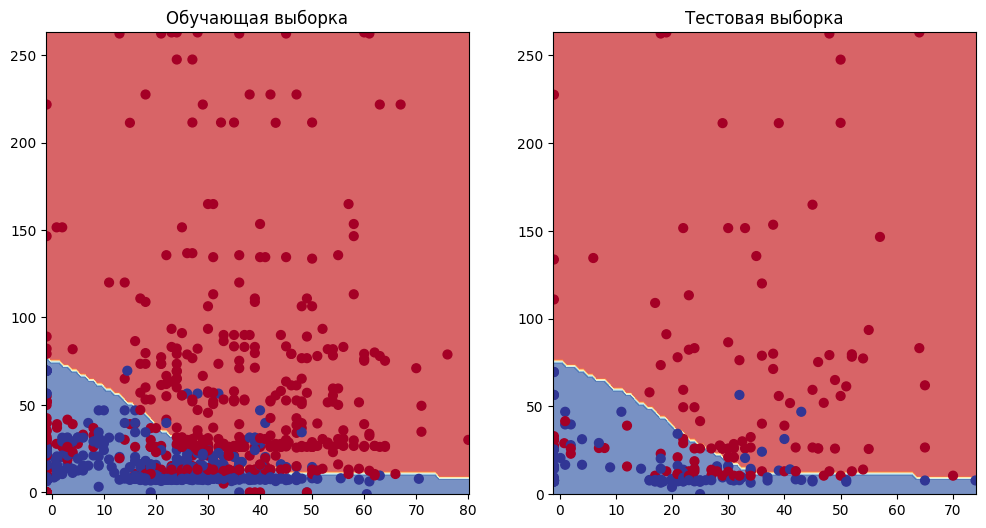

In [382]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Обучающая выборка")
plot_decision_boundary(model_2, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Тестовая выборка")
plot_decision_boundary(model_2, X=X_test, y=y_test)

313/313 [==============================] - 1s 2ms/step


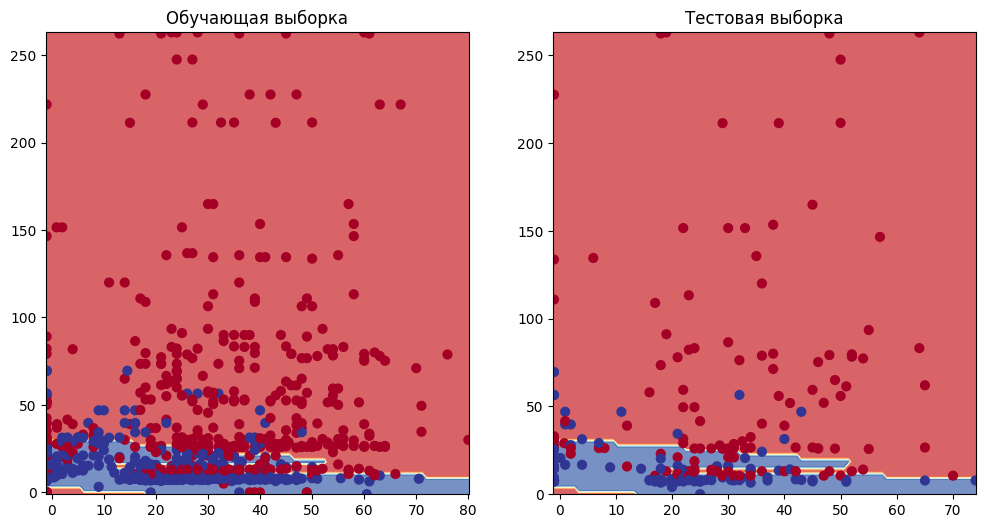

In [383]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Обучающая выборка")
plot_decision_boundary(model_3, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Тестовая выборка")
plot_decision_boundary(model_3, X=X_test, y=y_test)

313/313 [==============================] - 1s 2ms/step


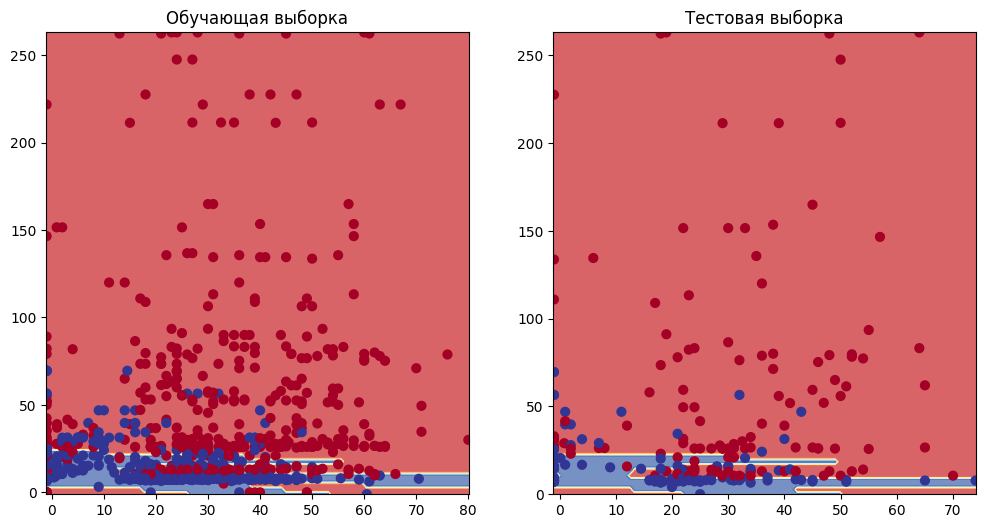

In [384]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Обучающая выборка")
plot_decision_boundary(model_4, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Тестовая выборка")
plot_decision_boundary(model_4, X=X_test, y=y_test)

6. Визуализируйте на одном рисунке ROC-кривые для построенных классификаторов на основе нейронных сетей, вычислите площади под ROC-кривыми методом трапеций или иным методом и создайте легенду с указанием площадей кривых.

In [385]:
prediction2 = model_2.predict(df[['age','fare']].values)
prediction2.shape

prediction3 = model_3.predict(df[['age','fare']].values)
prediction3.shape

prediction4 = model_4.predict(df[['age','fare']].values)
prediction4.shape

41/41 [==============================] - 0s 2ms/step


(1305, 1)

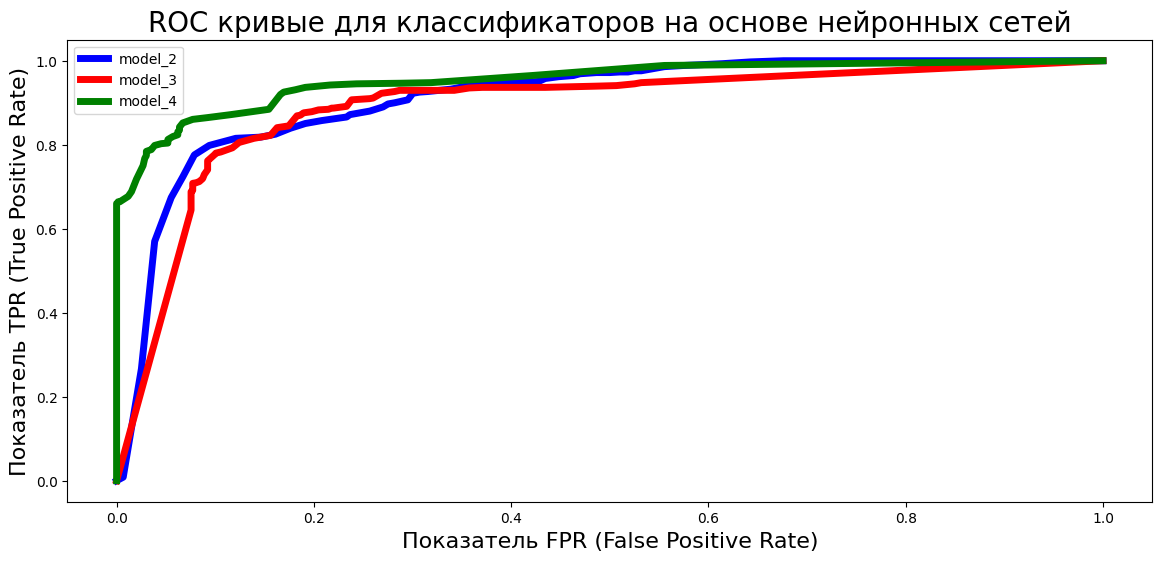

In [386]:
def true_false_positive(threshold_vector, y_test):
    true_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 1)
    true_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 0)
    false_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 0)
    false_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 1)

    tpr = true_positive.sum() / (true_positive.sum() + false_negative.sum())
    fpr = false_positive.sum() / (false_positive.sum() + true_negative.sum())

    return tpr, fpr

def roc_from_scratch(probabilities, y_test, partitions=100):
    roc = np.array([])
    for i in range(partitions + 1):

        threshold_vector = np.greater_equal(probabilities, i / partitions).astype(int)
        tpr, fpr = true_false_positive(threshold_vector, y_test)
        roc = np.append(roc, [fpr, tpr])

    return roc.reshape(-1, 2)

def auc(trp, fpr):
    area = np.trapz(trp, fpr)
    return area

plt.figure(figsize=(14,6))

ROC2 = roc_from_scratch(prediction2.reshape(-1),df['pclass'].values,partitions=50)
ROC3 = roc_from_scratch(prediction3.reshape(-1),df['pclass'].values,partitions=50)
ROC4 = roc_from_scratch(prediction4.reshape(-1),df['pclass'].values,partitions=50)

#plt.scatter(ROC[:,0],ROC[:,1],color='#0F9D58',s=100)
plt.plot(ROC2[:,0],ROC2[:,1],color='blue',lw=5, label = "model_2")
plt.plot(ROC3[:,0],ROC3[:,1],color='red',lw=5, label = "model_3")
plt.plot(ROC4[:,0],ROC4[:,1],color='green',lw=5, label = "model_4")

plt.title('ROC кривые для классификаторов на основе нейронных сетей',fontsize=20)
plt.xlabel('Показатель FPR (False Positive Rate)',fontsize=16)
plt.ylabel('Показатель TPR (True Positive Rate)',fontsize=16)
plt.legend()


In [387]:
auc_2 = auc(ROC2[:, 1], ROC2[:, 0])
auc_3 = auc(ROC3[:, 1], ROC3[:, 0])
auc_4 = auc(ROC4[:, 1], ROC4[:, 0])

print("Площадь под ROC-кривой для модели model_2:", auc_2)
print("Площадь под ROC-кривой для модели model_3:", auc_3)
print("Площадь под ROC-кривой для модели model_4:", auc_4)

Площадь под ROC-кривой для модели model_2: -0.9104975814314518
Площадь под ROC-кривой для модели model_3: -0.8887115324542554
Площадь под ROC-кривой для модели model_4: -0.9524651887051429


7. Определите исходном наборе данных дополнительный признак, отличный от указанных в задании двух независимых признаков, принимающий непрерывные значения и имеющий максимальную дисперсию.

In [388]:
variances = df.var()
max_variance_feature = variances.idxmax()

print(f"Признак с максимальной дисперсией: {max_variance_feature}")
# df_for_7

Признак с максимальной дисперсией: body


8. Визуализируйте точки набора данных в трехмерном пространстве с координатами, соответствующими трем независимым признакам, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду для классов набора данных.

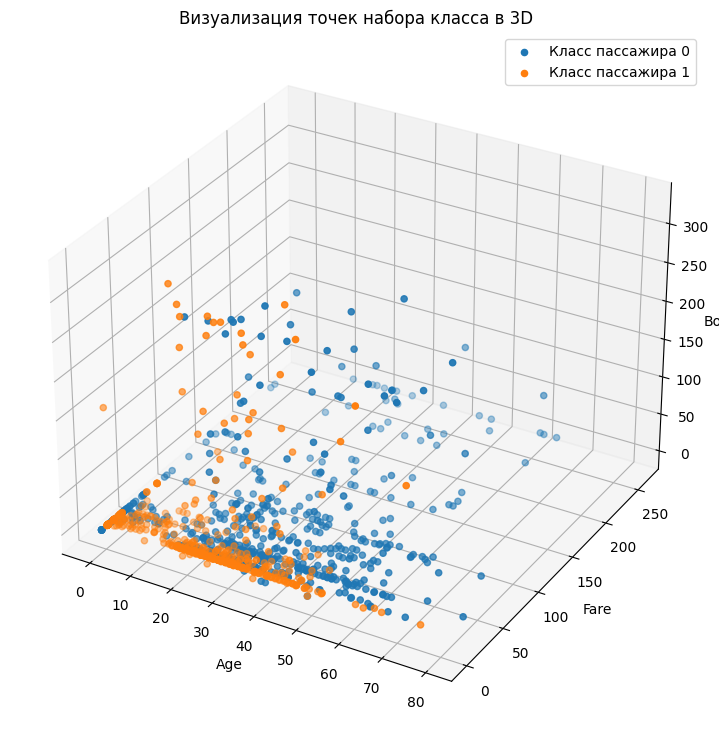

In [389]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')

for class_label, class_df in df.groupby('pclass'):
    ax.scatter(class_df['age'], class_df['fare'], class_df['body'], label=f'Класс пассажира {class_label}')

ax.set_title('Визуализация точек набора класса в 3D')
ax.set_xlabel('Age')
ax.set_ylabel('Fare')
ax.set_zlabel('Body')

ax.legend()
plt.grid(True)
plt.show()

9. Разбейте исходный набор данных на обучающую и тестовую выборки. Постройте нейронную сеть для многоклассовой классификации с нормализующим слоем и параметрами, соответствующими лучшей нейронной сети для бинарной классифиации из п.4, и обучите ее на обучающей выборке, контролируя процесс ее обучения.

In [390]:
ds = tfds.load("titanic", split="train")
df_for_9 = tfds.as_dataframe(ds)
df_for_9.drop(columns = ['boat', 'cabin', 'home.dest', 'name', 'ticket'], inplace = True)
df_for_9.head()

,age,body,embarked,fare,parch,pclass,sex,sibsp,survived
0,30.0,-1,2,13.0000,0,1,0,0,0
1,37.0,98,2,7.9250,0,2,0,2,0
2,28.0,-1,2,13.0000,0,1,1,0,1
3,18.0,-1,2,73.5000,0,1,0,0,0
4,-1.0,-1,0,7.8958,0,2,0,0,0


In [391]:
X = np.array(df_for_9.drop('pclass', axis=1))
y = np.array(df_for_9['pclass'])

In [392]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_ratio=0.2, seed=42)
y_train.shape, y_test.shape

((1048,), (261,))

In [393]:
def to_one_hot(labels, dimension=3):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)
y_train.shape, y_test.shape

y_train

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [394]:
feature_normalizer = tf.keras.layers.Normalization(axis=None,input_shape=(X.shape[1],))
feature_normalizer.adapt(X_train)

In [395]:
model_9 = tf.keras.Sequential([
    feature_normalizer,
    tf.keras.layers.Dense(64, activation='selu'),
    tf.keras.layers.Dense(64, activation='selu'),
    tf.keras.layers.Dense(64, activation='selu'),
    tf.keras.layers.Dense(64, activation='selu'),
    tf.keras.layers.Dense(3, activation="softmax")
    # tf.keras.layers.Dense(1, activation='sigmoid')
])

In [396]:
# model_9.compile(optimizer="rmsprop",
#               loss="categorical_crossentropy",
#               metrics=["accuracy"])


model_9.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    # metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
    metrics=[tf.keras.metrics.FalsePositives(name='accuracy of FP')]
)

In [397]:
history = model_9.fit(X_train,
                    y_train,
                    epochs=100,
                    # уровень выводимой информации
                    verbose=1,
                    # проверка (валидация) на 20% обучающих данных
                    validation_split = 0.2)

Epoch 1/100
27/27 [==============================] - 2s 13ms/step - loss: 0.5017 - accuracy of FP: 239.0000 - val_loss: 0.5078 - val_accuracy of FP: 69.0000
Epoch 2/100
27/27 [==============================] - 0s 4ms/step - loss: 0.4218 - accuracy of FP: 226.0000 - val_loss: 0.4539 - val_accuracy of FP: 52.0000
Epoch 3/100
27/27 [==============================] - 0s 5ms/step - loss: 0.3936 - accuracy of FP: 198.0000 - val_loss: 0.3985 - val_accuracy of FP: 46.0000
Epoch 4/100
27/27 [==============================] - 0s 4ms/step - loss: 0.3775 - accuracy of FP: 194.0000 - val_loss: 0.4008 - val_accuracy of FP: 51.0000
Epoch 5/100
27/27 [==============================] - 0s 4ms/step - loss: 0.3569 - accuracy of FP: 181.0000 - val_loss: 0.4136 - val_accuracy of FP: 59.0000
Epoch 6/100
27/27 [==============================] - 0s 5ms/step - loss: 0.3448 - accuracy of FP: 186.0000 - val_loss: 0.3835 - val_accuracy of FP: 49.0000
Epoch 7/100
27/27 [==============================] - 0s 5ms/ste

10. Постройте кривые обучения в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду.


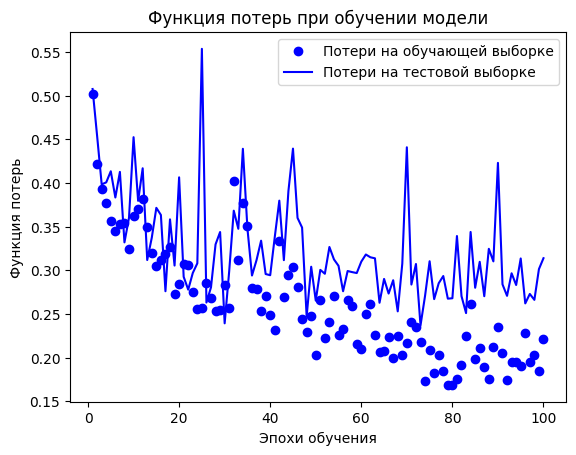

In [398]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Потери на обучающей выборке")
plt.plot(epochs, val_loss, "b", label="Потери на тестовой выборке")
plt.title("Функция потерь при обучении модели")
plt.xlabel("Эпохи обучения")
plt.ylabel("Функция потерь")
plt.legend();